#  구글 드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 패키지 설치

In [4]:
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install konlpy
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3 
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-56z4h_39
  Running command git clone --filter=blob:none --quiet https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-56z4h_39
  Resolved https://github.com/ssut/py-hanspell.git to commit 8e993cf46f97f9d665c15633a0fc78ac1b727713
  Preparing metadata (setup.py) ... done
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4870 sha256=5964e3a2579c1f5d666568948c1896fab1e232fa33a7926a8dc57f40d4e936ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-onj8d486/wheels/3f/a5/73/e4d2806ae141d274fdddaabf8c0ed79be9357d36bfdc99e4b4
Successfully built py-hanspell
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 3

In [6]:
# 데이터 처리 
import pandas as pd 
import numpy as np

# 시각화 
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt 


# 한글 글꼴 설정
mpl.rc('font',family ='Malgun Gothic')
# 음수값 설정 
mpl.rc('axes',unicode_minus= True )

import re

from hanspell import spell_checker

from sklearn.model_selection import train_test_split

from konlpy.tag import Okt

# LSTM
import tensorflow 
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import Dropout, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# 파일 불러오기

In [7]:
df_data1 = pd.read_excel('/content/drive/MyDrive/data1.xlsx', engine='openpyxl')
df_data2 = pd.read_excel('/content/drive/MyDrive/data2.xlsx', engine='openpyxl')
df_stopword = pd.read_csv('/content/drive/MyDrive/stopword.txt', header = None, names = ['불용어'])

df_test = pd.read_excel('/content/drive/MyDrive/input_data.xlsx', engine='openpyxl')

# 모델 학습하기

In [8]:
# 데이터 병합
df = pd.concat([df_data1, df_data2], sort = False)
df = df.sort_values(by = ['NO'])
df = df.reset_index(drop = True)


# 발화 1개 여러개 분리
cond1 = df['발화2'].isnull()
df_one = df[cond1]
df_many = df[~cond1]


# 분류 수정
df1 = df_one[['NO', 'NO2', '발화', '발화1', '발화1의 우선순위']]
df1 = df1.reset_index(drop = True)
df1['수정된 분류'] = df1['발화1']

cond2 = df1['수정된 분류'] == '중립'
cond3 = df1['수정된 분류'] == '폐기'
df1_neutral = df1[cond2]
df1_discard = df1[cond3]

df1_neutral_good = df1_neutral[df1_neutral.columns]
df1_neutral_bad = df1_neutral[df1_neutral.columns]

df1_neutral_good['수정된 분류'] = '칭찬>기타>중립'
df1_neutral_bad['수정된 분류'] = '불만>기타>중립'

df1_1 = df1[~cond2]
df1_2 = pd.concat([df1_1, df1_neutral_good], sort = False)
df2 = pd.concat([df1_2, df1_neutral_bad], sort = False)
df2 = df2.reset_index(drop = True)

df2.loc[df2['수정된 분류']=='칭찬>고객서비스', '수정된 분류'] = '칭찬>고객서비스>고객서비스'
df2.loc[df2['수정된 분류']=='칭찬>삼성카드', '수정된 분류'] = '칭찬>삼성카드>삼성카드'
df2.loc[df2['수정된 분류']=='칭찬>기타', '수정된 분류'] = '칭찬>기타>기타'
df2.loc[df2['수정된 분류']=='불만>고객서비스', '수정된 분류'] = '불만>고객서비스>고객서비스'
df2.loc[df2['수정된 분류']=='불만>삼성카드', '수정된 분류'] = '불만>삼성카드>삼성카드'
df2.loc[df2['수정된 분류']=='불만>기타', '수정된 분류'] = '불만>기타>기타'


# 레이블링
df3 = df2[df2.columns]
df3[['분류1','분류2','분류3']] = df3['수정된 분류'].str.split('>',n=3, expand=True)

df4 = df3[df3.columns]
df4['document'] = df4['발화']

dic1 = {'칭찬' : 0, '불만' : 1}
dic2 = {'고객서비스' : 0, '삼성카드' : 1, '기타' : 2}
dic3_0 = {'상담원' : 0, '상담시스템' : 1, '고객서비스' : 2}
dic3_1 = {'혜택' : 0, '할부금융상품' : 1, '커뮤니티서비스' : 2, '카드이용/결제' : 3, 
          '카드상품' : 4, '청구입금' : 5, '심사/한도' : 6, '생활편의서비스' : 7, 
          '상담/채널' : 8, '리스렌탈상품' : 9, '라이프서비스' : 10, '금융상품' : 11, 
          '고객정보관리' : 12, '가맹점매출/승인' : 13, '가맹점대금' : 14, '가맹점계약' : 15, '삼성카드' : 16}
dic3_2 = {'기타' : 0, '중립' : 1, '폐기' : 2}

for i in df4.index :
    df4.loc[i, 'label1'] = dic1[df4.loc[i, '분류1']]
    df4.loc[i, 'label2'] = dic2[df4.loc[i, '분류2']]
    if df4.loc[i, '분류2'] == '고객서비스' :
        df4.loc[i, 'label3'] = dic3_0[df4.loc[i, '분류3']]
    elif df4.loc[i, '분류2'] == '삼성카드' :
        df4.loc[i, 'label3'] = dic3_1[df4.loc[i, '분류3']]
    elif df4.loc[i, '분류2'] == '기타' :
        df4.loc[i, 'label3'] = dic3_2[df4.loc[i, '분류3']]
    else :
        print(i)
        
df4[['label1', 'label2', 'label3']] = df4[['label1', 'label2', 'label3']].astype('int')        


# 맞춤법 교정을 위한
# 특수문자 삭제
df5 = df4[df4.columns]
df5["document"] = df5["document"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

# 이중 space 제거
df6 = df5[df5.columns]
new_document = []
for sent in df6['document'] :
    changed_sent = re.sub(' +', ' ', sent)
    new_document.append(changed_sent)

df6['document'] = new_document

In [9]:
import time
from IPython.display import display, clear_output

df7 = df6[df6.columns]

start = time.time()  # 시작 시간 저장

changed_document = []
i = 0
for sent in df7['document'] :
    
    clear_output(wait=True)
    i += 1
    
    spelled_sent = spell_checker.check(sent)
    checked_sent = spelled_sent.checked
    changed_document.append(checked_sent)
    
    print('진행 상황 : ', i,'/',len(df7['document']))
    print('진행 시간 : ', round((time.time() - start),2))

print('총 걸린 시간 : ', round((time.time() - start),2), '초')

df7['document'] = changed_document

진행 상황 :  9692 / 9692
진행 시간 :  1578.27
총 걸린 시간 :  1578.27 초


In [10]:
# 1차 분류를 위한 dataset
cond11 = (df7['분류3'] == '중립')
df_class_1 = df7.loc[~cond11][['document', 'label1']]

# 2차 분류를 위한 dataset
cond12 = (df7['분류3'] == '중립' )&(df7['분류1'] == '칭찬' )
df_class_2 = df7.loc[~cond12][['document', 'label2']]

# 2차 분류를 위한 dataset - 1차분류 결과로 따로 할 경우
cond13 = (df7['분류1'] == '칭찬')
cond14 = (df7['분류1'] == '불만')
df_class_2_0 = df7.loc[cond13][['document', 'label2']]
df_class_2_1 = df7.loc[cond14][['document', 'label2']]

# 3차 분류를 위한 dataset
cond15 = (df7['분류2'] == '고객서비스')
cond16 = (df7['분류2'] == '삼성카드')
cond17 = (df7['분류2'] == '기타')
cond18 = (df7['분류3'] == '중립' )&(df7['분류1'] == '칭찬' )
df_class_3_0 = df7.loc[cond15][['document', 'label3']]
df_class_3_1 = df7.loc[cond16][['document', 'label3']]
df_class_3_2 = df7.loc[cond17].loc[~cond18][['document', 'label3']]
# print(len(df_class_3_0), len(df_class_3_1), len(df_class_3_2))

In [11]:
# 시드값 설정 
seed = 6124
np.random.seed(seed)

x_train_1 , x_test_1, y_train_1, y_test_1 = train_test_split(df_class_1['document'], 
                                                             df_class_1['label1'], 
                                                             test_size = 0.2, 
                                                             random_state = seed)

x_train_2 , x_test_2, y_train_2, y_test_2 = train_test_split(df_class_2['document'], 
                                                             df_class_2['label2'], 
                                                             test_size = 0.2, 
                                                             random_state = seed)

x_train_3_0 , x_test_3_0 , y_train_3_0 , y_test_3_0  = train_test_split(df_class_3_0['document'],
                                                                        df_class_3_0['label3'], 
                                                                        test_size = 0.2, 
                                                                        random_state = seed)

x_train_3_1 , x_test_3_1 , y_train_3_1 , y_test_3_1  = train_test_split(df_class_3_1['document'],
                                                                        df_class_3_1['label3'], 
                                                                        test_size = 0.2, 
                                                                        random_state = seed)

x_train_3_2 , x_test_3_2 , y_train_3_2 , y_test_3_2  = train_test_split(df_class_3_2['document'],
                                                                        df_class_3_2['label3'], 
                                                                        test_size = 0.2, 
                                                                        random_state = seed)

In [12]:
# 불용어 및 특수 기호 처리함수 구성 
def stopword_function(X):
    clean_train_review = []
    okt = Okt()
    # 모든 X 값에 대해 불용어 및 특수기호 처리 
    for i in X:

        # 문자데이터에 대한 불용어 처리 
        if type(i) == str:
            # 한글 자음, 모음 처리
            review_text = re.sub("([ㄱ-ㅎㅏ-ㅣ]+)", "", i) 
            # 특수 문자 처리 
            review_text = re.sub("[^\w\s]", "", review_text) 
            # Tokenizing & Stemming 
            word_text = okt.morphs(review_text,stem=True)
            # StopWord 
            word_text = [token for token in word_text if not token in stopword_set]  

            clean_train_review.append(word_text)

        # 숫자데이터가 오는 경우, 공백을 append     
        else:
            clean_train_review.append([])
            
    return clean_train_review


# 이중 리스트에서 해당 요소와 그 앞뒤 요소 출력하는 함수
def find_letter_with_before_and_after(double_list, x) :
    i = 0
    for text in double_list :
        if str(x) in text :
            i += 1
            if text.index(str(x)) == 0 :
                print(text[text.index(str(x))], text[text.index(str(x))+1])
            elif text.index(str(x)) >= len(text)-1 :
                print(text[text.index(str(x))-1],text[text.index(str(x))])
            else :
                print(text[text.index(str(x))-1],text[text.index(str(x))], text[text.index(str(x))+1])
    print('총, ', i, '개')

    
# 리스트의 특정 요소 인덱스 모두 찾는 함수
def find_index(data, target):
    res = []
    lis = data
    while True:
        try:
            res.append(lis.index(target) + (res[-1]+1 if len(res)!=0 else 0))
            lis = data[res[-1]+1:]
        except:
            break     
    return res


# 리스트의 특정 요소 모두 삭제하는 함수
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]


# 이중 리스트에서 두 단어를 합치는 함수 
def combine_two_words(double_list, word1, word2) :
    c_double_list = double_list
    for i in range(len(c_double_list)) :
        if str(word1) in c_double_list[i] :
            for j in find_index(c_double_list[i], str(word1)) :
                if j < len(c_double_list[i])-1 :
                    if c_double_list[i][j+1] == str(word2) :
                        c_double_list[i][j] = str(word1)+str(word2)
                        c_double_list[i][j+1] = '삭제할 문자'
            
            c_double_list[i] = remove_values_from_list(c_double_list[i], '삭제할 문자')
            
    return c_double_list


# 이중 리스트에서 한 단어 삭제하는 함수
def remove_one_word(double_list, word) :
    r_double_list = double_list
    for i in range(len(r_double_list)) :
        if str(word) in r_double_list[i] :
            r_double_list[i] = remove_values_from_list(r_double_list[i], str(word))

    return r_double_list


# 이중 리스트에서 한 단어 변경하는 함수
def change_one_word(double_list, word, changed_word) :
    co_double_list = double_list
    for i in range(len(co_double_list)) :
        if str(word) in co_double_list[i] :
            for j in find_index(co_double_list[i], str(word)) :
                co_double_list[i][j] = str(changed_word)

    return co_double_list


# 추가 전처리
def additional_cleaning(double_list) :
    
    # 원
    double_list = combine_two_words(double_list, '상담', '원')

    double_list = combine_two_words(double_list, '상당', '원')
    double_list = change_one_word(double_list, '상당원', '상담원')

    double_list = combine_two_words(double_list, '안내', '원')

    double_list = combine_two_words(double_list, '원', '치')
    double_list = change_one_word(double_list, '원치', '원하지')

    double_list = combine_two_words(double_list, '상사', '원')
    double_list = change_one_word(double_list, '상사원', '상담원')

    double_list = combine_two_words(double_list, '상대', '원')
    double_list = change_one_word(double_list, '상대원', '상담원')

    double_list = combine_two_words(double_list, '칙', '원')
    double_list = change_one_word(double_list, '칙원', '직원')

    double_list = combine_two_words(double_list, '칙', '원')

    double_list = change_one_word(double_list, '결시', '연결')
    double_list = change_one_word(double_list, '간이', '시간')

    # 지
    double_list = combine_two_words(double_list, '지', '원금')

    double_list = combine_two_words(double_list, '지', '연')

    double_list = combine_two_words(double_list, '알', '지')

    double_list = combine_two_words(double_list, '지', '양')

    double_list = combine_two_words(double_list, '지', '양해')
    double_list = change_one_word(double_list, '지양해', '지양')
    
    # 대
    double_list = combine_two_words(double_list, '대', '기')

    double_list = combine_two_words(double_list, '대', '체적')

    double_list = combine_two_words(double_list, '대', '출사')

    double_list = combine_two_words(double_list, '대', '화법')

    double_list = combine_two_words(double_list, '대', '금도')

    double_list = combine_two_words(double_list, '현', '대')

    # OOO
    double_list = remove_one_word(double_list, 'OOO')
    
    return double_list


# 이중 리스트 복제 함수
def copy_double_list(double_list) : 
    copied_double_list = []
    for i in range(len(double_list)) :
        line = []
        for j in range(len(double_list[i])):
            line.append(double_list[i][j])
        copied_double_list.append(line)
        
    return copied_double_list

In [13]:
stopword_set = set(df_stopword['불용어'].values.tolist())

x_train_1_clean = stopword_function(x_train_1)
x_train_1_clean = additional_cleaning(x_train_1_clean)

x_train_2_clean = stopword_function(x_train_2)
x_train_2_clean = additional_cleaning(x_train_2_clean)

x_train_3_0_clean = stopword_function(x_train_3_0)
x_train_3_0_clean = additional_cleaning(x_train_3_0_clean)
x_train_3_1_clean = stopword_function(x_train_3_1)
x_train_3_1_clean = additional_cleaning(x_train_3_1_clean)
x_train_3_2_clean = stopword_function(x_train_3_2)
x_train_3_2_clean = additional_cleaning(x_train_3_2_clean)


x_test_1_clean = stopword_function(x_test_1)
x_test_1_clean = additional_cleaning(x_test_1_clean)

x_test_2_clean = stopword_function(x_test_2)
x_test_2_clean = additional_cleaning(x_test_2_clean)

x_test_3_0_clean = stopword_function(x_test_3_0)
x_test_3_0_clean = additional_cleaning(x_test_3_0_clean)
x_test_3_1_clean = stopword_function(x_test_3_1)
x_test_3_1_clean = additional_cleaning(x_test_3_1_clean)
x_test_3_2_clean = stopword_function(x_test_3_2)
x_test_3_2_clean = additional_cleaning(x_test_3_2_clean)

In [14]:
tensorflow.compat.v1.set_random_seed(196)

vocab_size_1 = 2000
model_token_1 = Tokenizer(num_words = vocab_size_1)
model_token_1.fit_on_texts(x_train_1_clean)
x_sequences_1 = model_token_1.texts_to_sequences(x_train_1_clean)
max_length_1 = 80
train_x_1 = pad_sequences(x_sequences_1, maxlen = max_length_1, padding = 'post')
train_y_1 = to_categorical(y_train_1.astype(int))


vocab_size_2 = 2000
model_token_2 = Tokenizer(num_words = vocab_size_2)
model_token_2.fit_on_texts(x_train_2_clean)
x_sequences_2 = model_token_2.texts_to_sequences(x_train_2_clean)
max_length_2 = 80
train_x_2 = pad_sequences(x_sequences_2, maxlen = max_length_2, padding = 'post')
train_y_2 = to_categorical(y_train_2.astype(int))


vocab_size_3_0 = 2000
model_token_3_0 = Tokenizer(num_words = vocab_size_3_0)
model_token_3_0.fit_on_texts(x_train_3_0_clean)
x_sequences_3_0 = model_token_3_0.texts_to_sequences(x_train_3_0_clean)
max_length_3_0 = 80
train_x_3_0 = pad_sequences(x_sequences_3_0, maxlen = max_length_3_0, padding = 'post')
train_y_3_0 = to_categorical(y_train_3_0.astype(int))

vocab_size_3_1 = 2000
model_token_3_1 = Tokenizer(num_words = vocab_size_3_1)
model_token_3_1.fit_on_texts(x_train_3_1_clean)
x_sequences_3_1 = model_token_3_1.texts_to_sequences(x_train_3_1_clean)
max_length_3_1 = 80
train_x_3_1 = pad_sequences(x_sequences_3_1, maxlen = max_length_3_1, padding = 'post')
train_y_3_1 = to_categorical(y_train_3_1.astype(int))

vocab_size_3_2 = 2000
model_token_3_2 = Tokenizer(num_words = vocab_size_3_2)
model_token_3_2.fit_on_texts(x_train_3_2_clean)
x_sequences_3_2 = model_token_3_2.texts_to_sequences(x_train_3_2_clean)
max_length_3_2 = 80
train_x_3_2 = pad_sequences(x_sequences_3_2, maxlen = max_length_3_2, padding = 'post')
train_y_3_2 = to_categorical(y_train_3_2.astype(int))

In [15]:
vocab_size_2 = 2000
model_token_2_t = Tokenizer(num_words = vocab_size_2)
model_token_2_t.fit_on_texts(x_test_2_clean)
x_sequences_2_t = model_token_2_t.texts_to_sequences(x_test_2_clean)
max_length_2 = 80
test_x_2 = pad_sequences(x_sequences_2_t, maxlen = max_length_2, padding = 'post')
test_y_2 = to_categorical(y_test_2.astype(int))

In [16]:
def metrics_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs =range(1, len(acc)+1)

    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')
    plt.title('Accuracy Score')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss , label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Score')
    plt.legend()
    
    return plt.show()

In [17]:
# 1차 분류 모델

##GPU 사용 시
device = torch.device("cuda:0")
bertmodel, vocab = get_pytorch_kobert_model()

# 기본 Bert tokenizer 사용
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair) 

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [18]:
# 1차분류를 위한 발화 + label로 이루어진 리스트 신규 생성
# x_train_1_clean & y_train_1_clean 은 불용어 + 토크나이징을 동시에 처리된 데이터셋이고
# 1차분류에서는 따로 BERT Tokenizer를 쓸 예정이기에 토크나이징이 안되어있는 x_train_1 & y_train_1 사용

train_1_list = []
test_1_list = []

for q, label in zip(x_train_1, y_train_1)  :
    data = []
    data.append(q)
    data.append(str(label))

    train_1_list.append(data)

for q, label in zip(x_test_1, y_test_1)  :
    data = []
    data.append(q)
    data.append(str(label))

    test_1_list.append(data)

In [19]:
# Setting parameters
max_len = 64 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

data_train = BERTDataset(train_1_list, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test_1_list, 0, 1, tok, max_len, True, False)

# pytorch용 DataLoader 사용
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 2, 
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
  
# Bert 모델 불러오기
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# 정확도측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# 모델 학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
   
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.7521315813064575 train acc 0.421875
epoch 1 train acc 0.875390625


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 1 test acc 0.9755208333333333


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.11086080223321915 train acc 0.953125
epoch 2 train acc 0.9805989583333333


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 2 test acc 0.9822916666666667


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.005889113061130047 train acc 1.0
epoch 3 train acc 0.99296875


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 3 test acc 0.9864583333333333


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.0018796928925439715 train acc 1.0
epoch 4 train acc 0.996875


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 4 test acc 0.9859375


  0%|          | 0/120 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.0011980391573160887 train acc 1.0
epoch 5 train acc 0.9989583333333333


  0%|          | 0/30 [00:00<?, ?it/s]

epoch 5 test acc 0.9869791666666666


In [20]:
# 2차분류를 위한 발화 + label로 이루어진 리스트 신규 생성
# x_train_2_clean & y_train_2_clean 은 불용어 + 토크나이징을 동시에 처리된 데이터셋이고
# 2차분류에서는 따로 BERT Tokenizer를 쓸 예정이기에 토크나이징이 안되어있는 x_train_2 & y_train_2 사용

train_2_list = []
test_2_list = []

for q, label in zip(x_train_2, y_train_2)  :
    data = []
    data.append(q)
    data.append(str(label))

    train_2_list.append(data)

for q, label in zip(x_test_2, y_test_2)  :
    data = []
    data.append(q)
    data.append(str(label))

    test_2_list.append(data)

In [21]:
# 2차 분류 모델

# Setting parameters
max_len = 64 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

data_train = BERTDataset(train_2_list, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test_2_list, 0, 1, tok, max_len, True, False)

# pytorch용 DataLoader 사용
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 3, 
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
  
# Bert 모델 불러오기
model2 = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model2.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model2.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

# 정확도측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# 모델 학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model2.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model2(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
   
    model2.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model2(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/121 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.113446593284607 train acc 0.453125
epoch 1 train acc 0.7847669543023821


  0%|          | 0/31 [00:00<?, ?it/s]

epoch 1 test acc 0.9506048387096774


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.2602761387825012 train acc 0.921875
epoch 2 train acc 0.963227698104035


  0%|          | 0/31 [00:00<?, ?it/s]

epoch 2 test acc 0.9702620967741935


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.1188349798321724 train acc 0.9375
epoch 3 train acc 0.9838888551288284


  0%|          | 0/31 [00:00<?, ?it/s]

epoch 3 test acc 0.9717741935483871


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.021341897547245026 train acc 0.984375
epoch 4 train acc 0.9939307851239669


  0%|          | 0/31 [00:00<?, ?it/s]

epoch 4 test acc 0.9773185483870968


  0%|          | 0/121 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.021476279944181442 train acc 0.984375
epoch 5 train acc 0.9987086776859504


  0%|          | 0/31 [00:00<?, ?it/s]

epoch 5 test acc 0.9793346774193549


In [22]:
# 3-0차 분류 모델
earlystop_callback = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, patience = 5)

model_3_0 = Sequential([Embedding(vocab_size_3_0, 300, input_length =max_length_3_0),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(2, activation='softmax')
    ])

model_3_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_3_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 300)           600000    
                                                                 
 bidirectional (Bidirectiona  (None, 80, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                        

In [23]:
history_3_0 = model_3_0.fit(train_x_3_0, train_y_3_0,
                        epochs=40, batch_size=64, validation_split=0.2, callbacks=[earlystop_callback])

Epoch 1/40
59/59 [==============================] - 30s 104ms/step - loss: 0.2958 - acc: 0.8680 - val_loss: 0.0849 - val_acc: 0.9754
Epoch 2/40
59/59 [==============================] - 2s 36ms/step - loss: 0.0185 - acc: 0.9954 - val_loss: 0.0737 - val_acc: 0.9840
Epoch 3/40
59/59 [==============================] - 2s 29ms/step - loss: 0.0114 - acc: 0.9976 - val_loss: 0.0686 - val_acc: 0.9829
Epoch 4/40
59/59 [==============================] - 2s 37ms/step - loss: 0.0051 - acc: 0.9992 - val_loss: 0.0944 - val_acc: 0.9818
Epoch 5/40
59/59 [==============================] - 2s 42ms/step - loss: 0.0026 - acc: 0.9997 - val_loss: 0.1069 - val_acc: 0.9818
Epoch 6/40
59/59 [==============================] - 2s 42ms/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.0809 - val_acc: 0.9861
Epoch 7/40
59/59 [==============================] - 2s 29ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0965 - val_acc: 0.9840
Epoch 8/40
59/59 [==============================] - 2s 30ms/step - loss: 1.6623e-

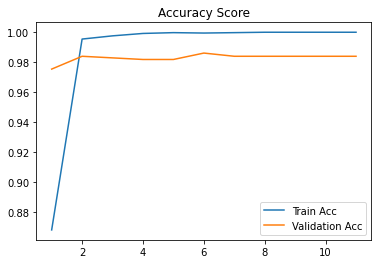

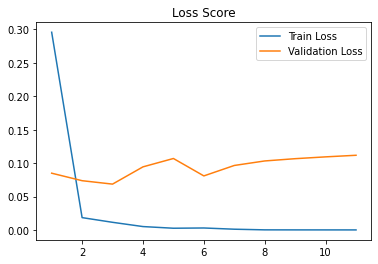

In [24]:
metrics_plot(history_3_0)

In [25]:
# 3-1차 분류 모델
earlystop_callback = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, patience = 5)

model_3_1 = Sequential([Embedding(vocab_size_3_1, 300, input_length =max_length_3_1),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(17, activation='softmax')
    ])

model_3_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_3_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 300)           600000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 80, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 17)                2193      
                                                      

In [26]:
history_3_1 = model_3_1.fit(train_x_3_1, train_y_3_1,
                        epochs=40, batch_size=64, validation_split=0.2, callbacks=[earlystop_callback])

Epoch 1/40
25/25 [==============================] - 33s 258ms/step - loss: 1.7826 - acc: 0.5514 - val_loss: 1.4337 - val_acc: 0.5612
Epoch 2/40
25/25 [==============================] - 1s 32ms/step - loss: 1.4187 - acc: 0.5693 - val_loss: 1.3527 - val_acc: 0.5612
Epoch 3/40
25/25 [==============================] - 1s 38ms/step - loss: 1.1024 - acc: 0.6345 - val_loss: 0.9009 - val_acc: 0.6658
Epoch 4/40
25/25 [==============================] - 2s 72ms/step - loss: 0.7343 - acc: 0.7450 - val_loss: 0.7701 - val_acc: 0.8036
Epoch 5/40
25/25 [==============================] - 1s 41ms/step - loss: 0.5197 - acc: 0.8466 - val_loss: 0.5552 - val_acc: 0.8265
Epoch 6/40
25/25 [==============================] - 1s 43ms/step - loss: 0.3558 - acc: 0.8856 - val_loss: 0.5089 - val_acc: 0.8469
Epoch 7/40
25/25 [==============================] - 1s 43ms/step - loss: 0.2608 - acc: 0.9310 - val_loss: 0.4933 - val_acc: 0.8801
Epoch 8/40
25/25 [==============================] - 1s 37ms/step - loss: 0.2011 -

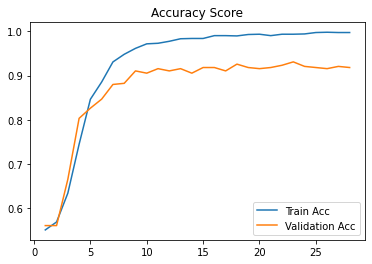

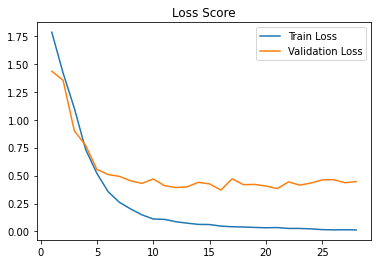

In [27]:
metrics_plot(history_3_1)

In [28]:
# 3-2차 분류 모델
earlystop_callback = EarlyStopping(monitor = 'val_acc', min_delta = 0.0001, patience = 5)

model_3_2 = Sequential([Embedding(vocab_size_3_2, 300, input_length =max_length_3_2),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(2, activation='softmax')
    ])

model_3_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_3_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 300)           600000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 80, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 80, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                      

In [29]:
history_3_2 = model_3_2.fit(train_x_3_2, train_y_3_2,
                        epochs=40, batch_size=64, validation_split=0.2, callbacks=[earlystop_callback])

Epoch 1/40
14/14 [==============================] - 29s 757ms/step - loss: 0.3155 - acc: 0.8782 - val_loss: 0.1730 - val_acc: 0.9579
Epoch 2/40
14/14 [==============================] - 1s 47ms/step - loss: 0.2055 - acc: 0.9415 - val_loss: 0.1522 - val_acc: 0.9579
Epoch 3/40
14/14 [==============================] - 1s 44ms/step - loss: 0.1557 - acc: 0.9496 - val_loss: 0.0872 - val_acc: 0.9766
Epoch 4/40
14/14 [==============================] - 1s 84ms/step - loss: 0.0459 - acc: 0.9883 - val_loss: 0.0311 - val_acc: 0.9907
Epoch 5/40
14/14 [==============================] - 0s 31ms/step - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0173 - val_acc: 0.9907
Epoch 6/40
14/14 [==============================] - 0s 30ms/step - loss: 0.0054 - acc: 0.9988 - val_loss: 0.0229 - val_acc: 0.9953
Epoch 7/40
14/14 [==============================] - 0s 33ms/step - loss: 0.0027 - acc: 0.9988 - val_loss: 0.0164 - val_acc: 0.9953
Epoch 8/40
14/14 [==============================] - 0s 30ms/step - loss: 7.3754e-

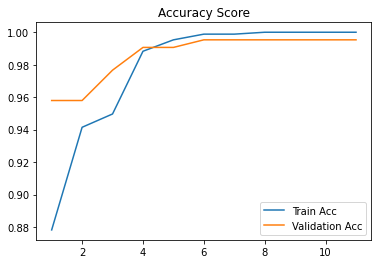

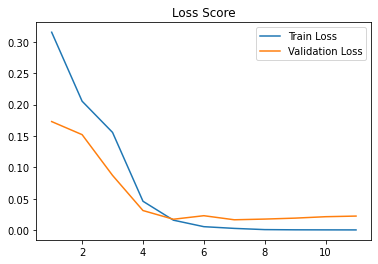

In [30]:
metrics_plot(history_3_2)

# 모델 분류하기

In [31]:
df_test = pd.read_excel('/content/drive/MyDrive/input_data.xlsx', engine='openpyxl')

In [32]:
import time
from IPython.display import display, clear_output
 # 시작 시간 저장
start = time.time() 

# 맞춤법 교정을 위한 특수문자 삭제
df_test["TEXT_cleaned"] = df_test["TEXT"].str.replace(pat=r'[^\w]', repl=r' ', regex=True)

# 맞춤법 교정을 위한이중 space 제거
new_document = []
for sent in df_test["TEXT_cleaned"] :
    changed_sent = re.sub(' +', ' ', sent)
    new_document.append(changed_sent)

df_test["TEXT_cleaned"] = new_document


# 맞춤법 교정
changed_document = []
i = 0
for sent in df_test["TEXT_cleaned"] :
    
    clear_output(wait=True)
    i += 1
    
    spelled_sent = spell_checker.check(sent)
    checked_sent = spelled_sent.checked
    changed_document.append(checked_sent)
    
    print('진행 상황 : ', i,'/',len(df_test["TEXT_cleaned"]))
    print('진행 시간 : ', round((time.time() - start),2))

print('총 걸린 시간 : ', round((time.time() - start),2), '초')

df_test["TEXT_cleaned"] = changed_document
df_test

진행 상황 :  1000 / 1000
진행 시간 :  157.28
총 걸린 시간 :  157.28 초


,KEY1,KEY2,TEXT,INT,TEXT_cleaned
0,1,6438,상담직원과 빠른연결했슴좋겠어요,NaN,상담직원과 빠른연결했슴좋겠어요
1,2,6850,안기다리고. 빨리상담되었음좋겠다,NaN,안 기다리고 빨리 상담되었으면 좋겠다
2,3,7294,너무 오래기다리고 상담이 늦어져요,NaN,너무 오래 기다리고 상담이 늦어져요
3,4,9484,상담직원과 통화가 매우 힘들다,NaN,상담직원과 통화가 매우 힘들다
4,5,10350,상담받으려면오래기다리는게불편함,NaN,상담받으려면 오래 기다리는 게 불편함
...,...,...,...,...,...
995,9958,103,카드분실된지 1분만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는데 감...,NaN,카드 분실된 지 1분 만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는...
996,9961,2,수시로 6개월무이자할부와 링크혜택이 다른카드와 구별되는 기능이 편리함,NaN,수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함
997,9962,4,무이자할부 자주 많이 주셔서감사합니다,NaN,무이자 할부 자주 많이 주셔서 감사합니다
998,9963,5,무이자혜택만족긴할부만족잘쓰고있습니다,NaN,무이자 혜택 만족 긴 할부 만족 잘 쓰고 있습니다


In [33]:
# 버트용
test_input_serires = df_test["TEXT_cleaned"]
test_input_serires

0                                       상담직원과 빠른연결했슴좋겠어요
1                                   안 기다리고 빨리 상담되었으면 좋겠다
2                                    너무 오래 기다리고 상담이 늦어져요
3                                       상담직원과 통화가 매우 힘들다
4                                   상담받으려면 오래 기다리는 게 불편함
                             ...                        
995    카드 분실된 지 1분 만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는...
996           수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함
997                               무이자 할부 자주 많이 주셔서 감사합니다
998                          무이자 혜택 만족 긴 할부 만족 잘 쓰고 있습니다
999                                  무이자 혜택이 많아 잘 쓰고 있어요
Name: TEXT_cleaned, Length: 1000, dtype: object

In [34]:
def stopword_function(X):
    clean_train_review = []
    okt = Okt()
    # 모든 X 값에 대해 불용어 및 특수기호 처리 
    for i in X:

        # 문자데이터에 대한 불용어 처리 
        if type(i) == str:
            # 한글 자음, 모음 처리
            review_text = re.sub("([ㄱ-ㅎㅏ-ㅣ]+)", "", i) 
            # 특수 문자 처리 
            review_text = re.sub("[^\w\s]", "", review_text) 
            # Tokenizing & Stemming 
            word_text = okt.morphs(review_text,stem=True)
            # StopWord 
            word_text = [token for token in word_text if not token in stopword_set]  

            clean_train_review.append(word_text)

        # 숫자데이터가 오는 경우, 공백을 append     
        else:
            clean_train_review.append([])
            
    return clean_train_review


# 이중 리스트에서 해당 요소와 그 앞뒤 요소 출력하는 함수
def find_letter_with_before_and_after(double_list, x) :
    i = 0
    for text in double_list :
        if str(x) in text :
            i += 1
            if text.index(str(x)) == 0 :
                print(text[text.index(str(x))], text[text.index(str(x))+1])
            elif text.index(str(x)) >= len(text)-1 :
                print(text[text.index(str(x))-1],text[text.index(str(x))])
            else :
                print(text[text.index(str(x))-1],text[text.index(str(x))], text[text.index(str(x))+1])
    print('총, ', i, '개')

    
# 리스트의 특정 요소 인덱스 모두 찾는 함수
def find_index(data, target):
    res = []
    lis = data
    while True:
        try:
            res.append(lis.index(target) + (res[-1]+1 if len(res)!=0 else 0))
            lis = data[res[-1]+1:]
        except:
            break     
    return res


# 리스트의 특정 요소 모두 삭제하는 함수
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]


# 이중 리스트에서 두 단어를 합치는 함수 
def combine_two_words(double_list, word1, word2) :
    c_double_list = double_list
    for i in range(len(c_double_list)) :
        if str(word1) in c_double_list[i] :
            for j in find_index(c_double_list[i], str(word1)) :
                if j < len(c_double_list[i])-1 :
                    if c_double_list[i][j+1] == str(word2) :
                        c_double_list[i][j] = str(word1)+str(word2)
                        c_double_list[i][j+1] = '삭제할 문자'
            
            c_double_list[i] = remove_values_from_list(c_double_list[i], '삭제할 문자')
            
    return c_double_list


# 이중 리스트에서 한 단어 삭제하는 함수
def remove_one_word(double_list, word) :
    r_double_list = double_list
    for i in range(len(r_double_list)) :
        if str(word) in r_double_list[i] :
            r_double_list[i] = remove_values_from_list(r_double_list[i], str(word))

    return r_double_list


# 이중 리스트에서 한 단어 변경하는 함수
def change_one_word(double_list, word, changed_word) :
    co_double_list = double_list
    for i in range(len(co_double_list)) :
        if str(word) in co_double_list[i] :
            for j in find_index(co_double_list[i], str(word)) :
                co_double_list[i][j] = str(changed_word)

    return co_double_list


# 추가 전처리
def additional_cleaning(double_list) :
    
    # 원
    double_list = combine_two_words(double_list, '상담', '원')

    double_list = combine_two_words(double_list, '상당', '원')
    double_list = change_one_word(double_list, '상당원', '상담원')

    double_list = combine_two_words(double_list, '안내', '원')

    double_list = combine_two_words(double_list, '원', '치')
    double_list = change_one_word(double_list, '원치', '원하지')

    double_list = combine_two_words(double_list, '상사', '원')
    double_list = change_one_word(double_list, '상사원', '상담원')

    double_list = combine_two_words(double_list, '상대', '원')
    double_list = change_one_word(double_list, '상대원', '상담원')

    double_list = combine_two_words(double_list, '칙', '원')
    double_list = change_one_word(double_list, '칙원', '직원')

    double_list = combine_two_words(double_list, '칙', '원')

    double_list = change_one_word(double_list, '결시', '연결')
    double_list = change_one_word(double_list, '간이', '시간')

    # 지
    double_list = combine_two_words(double_list, '지', '원금')

    double_list = combine_two_words(double_list, '지', '연')

    double_list = combine_two_words(double_list, '알', '지')

    double_list = combine_two_words(double_list, '지', '양')

    double_list = combine_two_words(double_list, '지', '양해')
    double_list = change_one_word(double_list, '지양해', '지양')
    
    # 대
    double_list = combine_two_words(double_list, '대', '기')

    double_list = combine_two_words(double_list, '대', '체적')

    double_list = combine_two_words(double_list, '대', '출사')

    double_list = combine_two_words(double_list, '대', '화법')

    double_list = combine_two_words(double_list, '대', '금도')

    double_list = combine_two_words(double_list, '현', '대')

    # OOO
    double_list = remove_one_word(double_list, 'OOO')
    
    return double_list


# 이중 리스트 복제 함수
def copy_double_list(double_list) : 
    copied_double_list = []
    for i in range(len(double_list)) :
        line = []
        for j in range(len(double_list[i])):
            line.append(double_list[i][j])
        copied_double_list.append(line)
        
    return copied_double_list

In [35]:
stopword_set = set(df_stopword['불용어'].values.tolist())

test_tok = stopword_function(df_test["TEXT_cleaned"])
test_tok = additional_cleaning(test_tok)

In [36]:
tensorflow.compat.v1.set_random_seed(196)

vocab_size_test = 2000

model_token_test = Tokenizer(num_words = vocab_size_test)
model_token_test.fit_on_texts(test_tok)

x_sequences_test = model_token_test.texts_to_sequences(test_tok)

max_length = 80
test_input = pad_sequences(x_sequences_test, maxlen = max_length, padding = 'post')

In [37]:
# 분류 1 진행 -> label_1 구해짐

import pandas as pd

# 위에서 설정한 tok, max_len, batch_size, device 그대로 사용
# comment : 예측하고자 하는 테스트 데이터 발화 리스트
def final_1_classification(comment, tok, max_len, batch_size, device):
  commnetslist = [] # 발화 리스트
  emo_list = [] # 1차 분류 값을 담을 리스트
  for c in comment: # 발화 리스트
    commnetslist.append( [c, 3] ) # [댓글, 임의의 양의 정수값] 설정
    
  pdData = pd.DataFrame( commnetslist, columns = [['발화', '1차분류']] )
  pdData = pdData.values
  test_set = BERTDataset(pdData, 0, 1, tok, max_len, True, False) 
  test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=0)
  
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_input):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length 
    out = model(token_ids, valid_length, segment_ids)
	
    for e in out:
      if e[0]>e[1]: 
        value = 0
      else: 
        value = 1
      emo_list.append(value)

  return emo_list 

import gc
gc.collect()
torch.cuda.empty_cache()

label_1 = final_1_classification(test_input_serires, tok, max_len, batch_size, device)

In [38]:
df_test['label1'] = label_1

In [39]:
# 분류 2 진행 -> label_2 구해짐

import pandas as pd

# 위에서 설정한 tok, max_len, batch_size, device 그대로 사용
# comment : 예측하고자 하는 테스트 데이터 발화 리스트
def final_2_classification(comment, tok, max_len, batch_size, device):
  commnetslist = [] # 발화 리스트
  emo_list = [] # 2차 분류 값을 담을 리스트
  for c in comment: # 발화 리스트
    commnetslist.append( [c, 4] ) # [댓글, 임의의 양의 정수값] 설정
    
  pdData = pd.DataFrame( commnetslist, columns = [['발화', '2차분류']] )
  pdData = pdData.values
  test_set = BERTDataset(pdData, 0, 1, tok, max_len, True, False) 
  test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=0)
  
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_input):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length 
    out = model2(token_ids, valid_length, segment_ids)

    for e in out:
      if e[0]>e[1] and e[0]>e[2]: 
        value = 0
      elif e[1]>e[0] and e[1]>e[2]:
        value = 1
      else:
        value = 2
      emo_list.append(value)

  return emo_list 
   

import gc
gc.collect()
torch.cuda.empty_cache()


label_2 = final_2_classification(test_input_serires, tok, max_len, batch_size, device)

In [40]:
df_test['label2'] = label_2

In [41]:
condt2_0 = (df_test['label2'] == 0)
condt2_1 = (df_test['label2'] == 1)
condt2_2 = (df_test['label2'] == 2)

df_test_3_0 = df_test.loc[condt2_0]
df_test_3_1 = df_test.loc[condt2_1]
df_test_3_2 = df_test.loc[condt2_2]

# 불용어 제거
stopword_set = set(df_stopword['불용어'].values.tolist())

# 토큰화
test_tok_3_0 = stopword_function(df_test_3_0["TEXT_cleaned"])
test_tok_3_0 = additional_cleaning(test_tok_3_0)

test_tok_3_1 = stopword_function(df_test_3_1["TEXT_cleaned"])
test_tok_3_1 = additional_cleaning(test_tok_3_1)

test_tok_3_2 = stopword_function(df_test_3_2["TEXT_cleaned"])
test_tok_3_2 = additional_cleaning(test_tok_3_2)


tensorflow.compat.v1.set_random_seed(196)

vocab_size_test = 2000
max_length = 80

model_token_test_3_0 = Tokenizer(num_words = vocab_size_test)
model_token_test_3_0.fit_on_texts(test_tok_3_0)
x_sequences_test_3_0 = model_token_test_3_0.texts_to_sequences(test_tok_3_0)
test_input_3_0 = pad_sequences(x_sequences_test_3_0, maxlen = max_length, padding = 'post')

model_token_test_3_1 = Tokenizer(num_words = vocab_size_test)
model_token_test_3_1.fit_on_texts(test_tok_3_1)
x_sequences_test_3_1 = model_token_test_3_1.texts_to_sequences(test_tok_3_1)
test_input_3_1 = pad_sequences(x_sequences_test_3_1, maxlen = max_length, padding = 'post')

model_token_test_3_2 = Tokenizer(num_words = vocab_size_test)
model_token_test_3_2.fit_on_texts(test_tok_3_2)
x_sequences_test_3_2 = model_token_test_3_2.texts_to_sequences(test_tok_3_2)
test_input_3_2 = pad_sequences(x_sequences_test_3_2, maxlen = max_length, padding = 'post')

In [42]:
# 분류3 진행 -> label_3_0, label_3_1, label_3_2 구해짐

# 모델 3_0 으로 라벨 3_0 예측
pred_3_0 = model_3_0.predict(test_input_3_0)
label_3_0 = np.argmax(pred_3_0, axis = 1)

# 모델 3_1 으로 라벨 3_1 예측
pred_3_1 = model_3_1.predict(test_input_3_1)
label_3_1 = np.argmax(pred_3_1, axis = 1)

# 모델 3_2 으로 라벨 3_2 예측
pred_3_2 = model_3_2.predict(test_input_3_2)
label_3_2 = np.argmax(pred_3_2, axis = 1)

5/5 [==============================] - 5s 16ms/step


In [43]:
df_test_3_0['label3'] = label_3_0
df_test_3_1['label3'] = label_3_1
df_test_3_2['label3'] = label_3_2

df_result = pd.concat([df_test_3_0, df_test_3_1], sort = False)
df_result = pd.concat([df_result, df_test_3_2], sort = False)

df_result = df_result.sort_index()
df_result

<ipython-input-43-8354334adfbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_3_0['label3'] = label_3_0
<ipython-input-43-8354334adfbb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_3_1['label3'] = label_3_1
<ipython-input-43-8354334adfbb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,KEY1,KEY2,TEXT,INT,TEXT_cleaned,label1,label2,label3
0,1,6438,상담직원과 빠른연결했슴좋겠어요,NaN,상담직원과 빠른연결했슴좋겠어요,0,0,0
1,2,6850,안기다리고. 빨리상담되었음좋겠다,NaN,안 기다리고 빨리 상담되었으면 좋겠다,0,0,0
2,3,7294,너무 오래기다리고 상담이 늦어져요,NaN,너무 오래 기다리고 상담이 늦어져요,0,0,0
3,4,9484,상담직원과 통화가 매우 힘들다,NaN,상담직원과 통화가 매우 힘들다,0,0,0
4,5,10350,상담받으려면오래기다리는게불편함,NaN,상담받으려면 오래 기다리는 게 불편함,0,0,1
...,...,...,...,...,...,...,...,...
995,9958,103,카드분실된지 1분만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는데 감...,NaN,카드 분실된 지 1분 만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린지도 몰랐는...,1,1,8
996,9961,2,수시로 6개월무이자할부와 링크혜택이 다른카드와 구별되는 기능이 편리함,NaN,수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함,1,1,5
997,9962,4,무이자할부 자주 많이 주셔서감사합니다,NaN,무이자 할부 자주 많이 주셔서 감사합니다,1,1,5
998,9963,5,무이자혜택만족긴할부만족잘쓰고있습니다,NaN,무이자 혜택 만족 긴 할부 만족 잘 쓰고 있습니다,1,1,5


In [44]:
df_result[['label1', 'label2', 'label3']] = df_result[['label1', 'label2', 'label3']].astype('int')        

dic1 = {'칭찬' : 0, '불만' : 1}
dic2 = {'고객서비스' : 0, '삼성카드' : 1, '기타' : 2}
dic3_0 = {'상담원' : 0, '상담시스템' : 1, '고객서비스' : 2}
dic3_1 = {'혜택' : 0, '할부금융상품' : 1, '커뮤니티서비스' : 2, '카드이용/결제' : 3, 
          '카드상품' : 4, '청구입금' : 5, '심사/한도' : 6, '생활편의서비스' : 7, 
          '상담/채널' : 8, '리스렌탈상품' : 9, '라이프서비스' : 10, '금융상품' : 11, 
          '고객정보관리' : 12, '가맹점매출/승인' : 13, '가맹점대금' : 14, '가맹점계약' : 15, '삼성카드' : 16}
dic3_2 = {'기타' : 0, '중립' : 1, '폐기' : 2}

dic1_reversed = {v:k for k, v in dic1.items()}
dic2_reversed = {v:k for k, v in dic2.items()}
dic3_0_reversed = {v:k for k, v in dic3_0.items()}
dic3_1_reversed = {v:k for k, v in dic3_1.items()}
dic3_2_reversed = {v:k for k, v in dic3_2.items()}

for i in df_result.index :
    df_result.loc[i, '분류1'] = dic1_reversed[df_result.loc[i, 'label1']]
    df_result.loc[i, '분류2'] = dic2_reversed[df_result.loc[i, 'label2']]
    if df_result.loc[i, 'label2'] == 0 :
        df_result.loc[i, '분류3'] = dic3_0_reversed[df_result.loc[i, 'label3']]
    elif df_result.loc[i, 'label2'] == 1 :
        df_result.loc[i, '분류3'] = dic3_1_reversed[df_result.loc[i, 'label3']]
    elif df_result.loc[i, 'label2'] == 2 :
        df_result.loc[i, '분류3'] = dic3_2_reversed[df_result.loc[i, 'label3']]
    else :
        print(i)
        
        
df_result['분류'] = df_result[['분류1', '분류2', '분류3']].apply('>'.join, axis=1)

df_result['복구된 분류'] = df_result['분류']

df_result.loc[df_result['복구된 분류']=='칭찬>고객서비스>고객서비스', '복구된 분류'] = '칭찬>고객서비스'
df_result.loc[df_result['복구된 분류']=='칭찬>삼성카드>삼성카드', '복구된 분류'] = '칭찬>삼성카드'
df_result.loc[df_result['복구된 분류']=='칭찬>기타>기타', '복구된 분류'] = '칭찬>기타'
df_result.loc[df_result['복구된 분류']=='불만>고객서비스>고객서비스', '복구된 분류'] = '불만>고객서비스'
df_result.loc[df_result['복구된 분류']=='불만>삼성카드>삼성카드', '복구된 분류'] = '불만>삼성카드'
df_result.loc[df_result['복구된 분류']=='불만>기타>기타', '복구된 분류'] = '불만>기타'

df_result.loc[df_result['복구된 분류']=='칭찬>기타>중립', '복구된 분류'] = '중립'
df_result.loc[df_result['복구된 분류']=='불만>기타>중립', '복구된 분류'] = '중립'

df_result['INT'] = df_result['복구된 분류']

In [45]:
df_final_result = df_result[['KEY1', 'KEY2', 'TEXT', 'INT']]

# 결과출력

In [46]:
df_final_result.to_excel('/content/drive/MyDrive/result_data.xlsx', index = False)